# Time Series Exploratory Data Analysis

Exploratory Data Analysis in time series datasets presents peculiarities that make it distinct from any other dataset. 
In this notebook, I explore the following:
- Classic Visualizations
    - Line Plot
    - Scatter Plot
- Time-Series Specific Analyses
    - Stationarity
    - Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Plotting functions
def plot_lineplot_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

def plot_scatter_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

# 0. Load Source Data
## 0.1 Air Passangers Dataset

In [3]:
AirPassengers = pd.read_csv("./datasets/AirPassengers.csv")
AirPassengers['Month'] = pd.to_datetime(AirPassengers['Month'])
AirPassengers.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


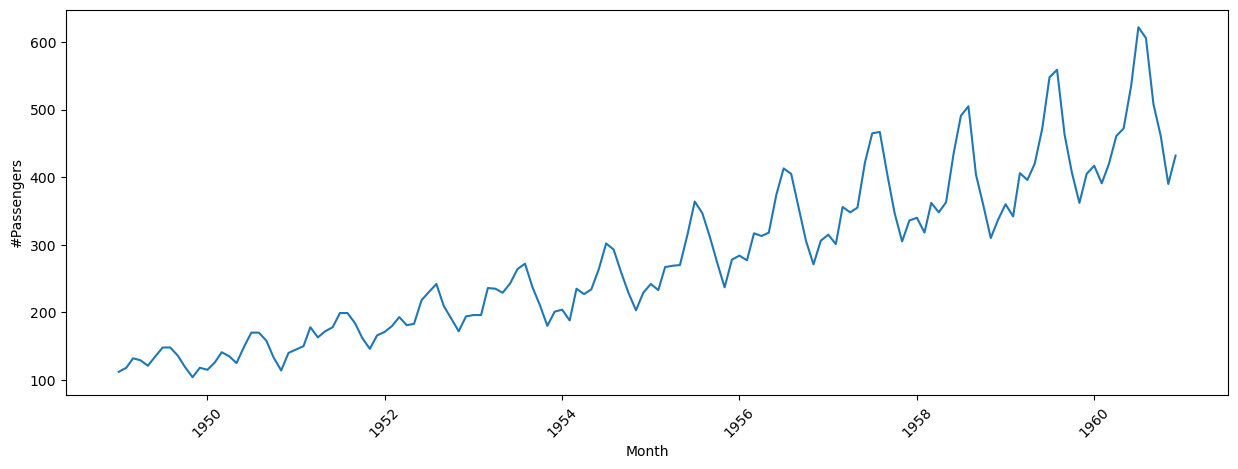

In [4]:
plot_lineplot_time_series(AirPassengers, "Month", "#Passengers")

## 0.2 Air Quality Dataset

In [5]:
# Initial loading - Separator is different here
AirQualityUCI = pd.read_csv("./datasets/AirQualityUCI.csv", sep=";")

# Convert date_column to datetime format
AirQualityUCI['Date'] = pd.to_datetime(AirQualityUCI['Date'])

# Convert time_column to timedelta format
AirQualityUCI['Time'] = pd.to_timedelta(AirQualityUCI['Time'].str.replace(".", ":"))

# Merge both fields
AirQualityUCI['DateTime'] = AirQualityUCI['Date'] + AirQualityUCI['Time']

# Drop columns
AirQualityUCI = AirQualityUCI.drop(['Date', 'Time'], axis=1)

# Reformat columns
cols = ['CO(GT)', 'T', 'RH', 'AH']
for col in cols:
    AirQualityUCI[col] = AirQualityUCI[col].str.replace(",", ".").replace('-200', None).astype('float')

# Take only an interval of dates
start_date = "23-03-2004"
end_date = "01-03-2005"
AirQualityUCI = AirQualityUCI.loc[(AirQualityUCI['DateTime'] >= start_date) & (AirQualityUCI['DateTime'] <= end_date)]

AirQualityUCI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6271 entries, 0 to 8526
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         4879 non-null   float64       
 1   PT08.S1(CO)    6271 non-null   float64       
 2   NMHC(GT)       6271 non-null   float64       
 3   C6H6(GT)       6271 non-null   object        
 4   PT08.S2(NMHC)  6271 non-null   float64       
 5   NOx(GT)        6271 non-null   float64       
 6   PT08.S3(NOx)   6271 non-null   float64       
 7   NO2(GT)        6271 non-null   float64       
 8   PT08.S4(NO2)   6271 non-null   float64       
 9   PT08.S5(O3)    6271 non-null   float64       
 10  T              6047 non-null   float64       
 11  RH             6047 non-null   float64       
 12  AH             6047 non-null   float64       
 13  Unnamed: 15    0 non-null      float64       
 14  Unnamed: 16    0 non-null      float64       
 15  DateTime       6271 n

/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_20160/2116898129.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AirQualityUCI['Date'] = pd.to_datetime(AirQualityUCI['Date'])
/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_20160/2116898129.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  AirQualityUCI['Time'] = pd.to_timedelta(AirQualityUCI['Time'].str.replace(".", ":"))
/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_20160/2116898129.py:24: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  AirQualityUCI = Ai

# 1. Classic visualizations

Two main plots:
- Line plot: Already discussed, showing the feature with time
- Scatter plot: Correlation between two variables

<Axes: xlabel='T', ylabel='RH'>

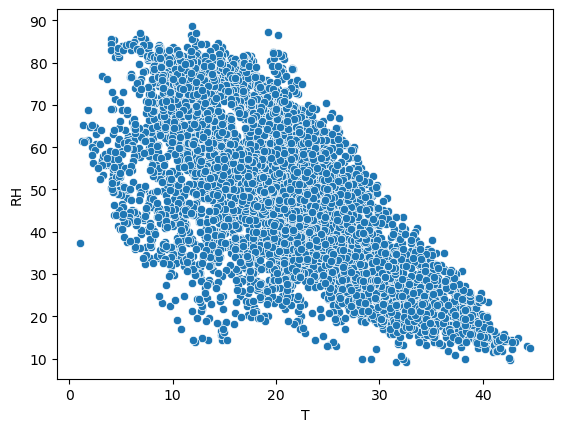

In [6]:
sns.scatterplot(data=AirQualityUCI, x='T', y='RH')

# 2. Time Series Specific Analyses

These analyses aim to unravel various statistical properties from the time series.
- Stationarity: Determine whether the time series represents a steady-state system.
    - For this analysis, I run the ADF
    - This is key for subsequent modelling, as some algorithms assume stationarity
- Self-correlation: Determine whether the various points of the time series are correlated to each other.
    - For this purpose, I calculate the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF)
    - This helps finding seasonalities and trends


In [7]:
def test_stationarity(timeseries):
    
    # Perform ADF test
    result = adfuller(timeseries, autolag='AIC')
    
    # Extract and print results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    
    # Interpret the results
    if result[1] <= 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")
        
# Assuming 'Passengers' is the column containing the passenger data
test_stationarity(AirPassengers['#Passengers'])


ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
Critical Values:
1%: -3.4816817173418295
5%: -2.8840418343195267
10%: -2.578770059171598
The series is likely non-stationary.


As the ADF p-value is 0.99, I can't discard the null hypothesis. Hence, the TS is non-stationary.

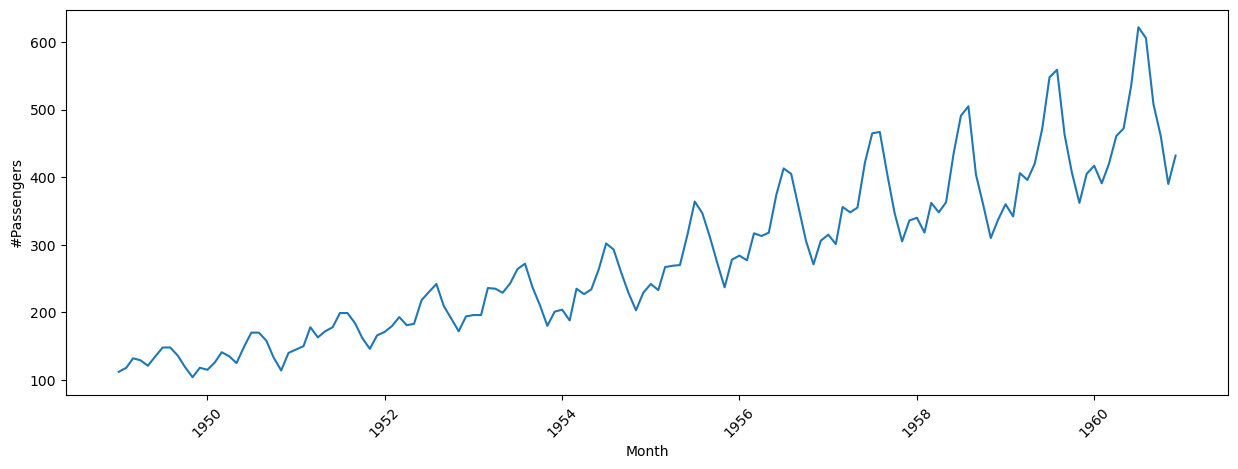

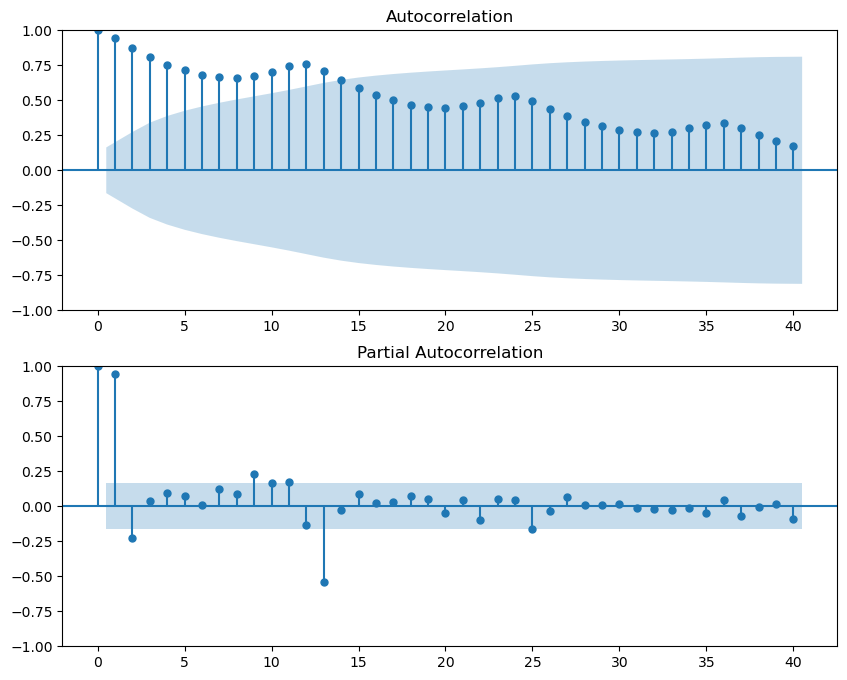

In [8]:
plot_lineplot_time_series(AirPassengers, "Month", "#Passengers")

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(AirPassengers['#Passengers'], ax=ax1, lags=40)
plot_pacf(AirPassengers['#Passengers'], ax=ax2, lags=40)
plt.show()

From these ACF and PACF graphs, we can extract the following insights:
- Most points are correlated with each other, which indicates that numbers from the same season are likely to have similar values.
- The PACF shows a peak on month 13, where the trend is inversed. This indicates a yearly seasonality.